# Unperturbed Tracing

Tracing was done in vaccuum assumption ($I = 0, G' = 0, K = 0$), and particles were distributed randomly and uniformly in volume.

In [1]:
import logging
import sys
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt

from simsopt.field.boozermagneticfield import (
        BoozerRadialInterpolant,
        InterpolatedBoozerField,
        ShearAlfvenHarmonic,
        ShearAlfvenWavesSuperposition
        )
from simsopt._core.util import parallel_loop_bounds
from simsopt.field.tracing import (
        MaxToroidalFluxStoppingCriterion,
        MinToroidalFluxStoppingCriterion,
        IterationStoppingCriterion,
        trace_particles_boozer_perturbed
)
from simsopt.util.constants import (
        ALPHA_PARTICLE_MASS as MASS,
        ALPHA_PARTICLE_CHARGE as CHARGE,
        FUSION_ALPHA_PARTICLE_ENERGY as ENERGY
)
from simsopt.util.constants import ALPHA_PARTICLE_MASS, ALPHA_PARTICLE_CHARGE, FUSION_ALPHA_PARTICLE_ENERGY
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d
import stellgap as sg
from scipy import integrate
from matplotlib.cm import ScalarMappable
import simsoptpp as sopp




# ---------- ASSUMPTIONS ------------
tracing = "gc_vac"
tol = 1e-10
resolution = 15
helicity = -1

[login21:409549] mca_base_component_repository_open: unable to open mca_btl_openib: /usr/lib64/libnl-3.so.200: version `libnl_3_5' not found (required by /global/homes/b/billert/.conda/envs/testing_cuda_compiler/lib/openmpi/.././libnl-route-3.so.200) (ignored)


In [2]:
np.random.seed(0)

boozmn_filename = 'boozmn_precise_QH.nc'
nParticles = 10 # Number of particles
resolution = 15
ns_interp = resolution
ntheta_interp = resolution
nzeta_interp = resolution
ntheta_min = 100
nzeta_min = 100
ns_min = 100

## Setup Booz_xform object
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(boozmn_filename)
nfp = equil.nfp

## Call boozxform and setup radial interpolation
order = 3
bri = BoozerRadialInterpolant(equil,order,no_K=False,N=nfp*-1)

## Setup 3d interpolation
degree = 3
srange = (0, 1, ns_interp)
thetarange = (0, np.pi, ntheta_interp)
zetarange = (0, 2*np.pi/nfp, nzeta_interp)
field = InterpolatedBoozerField(bri, degree, srange, thetarange, zetarange, True, nfp=nfp, stellsym=True)

Ekin=FUSION_ALPHA_PARTICLE_ENERGY
mass=ALPHA_PARTICLE_MASS
charge=ALPHA_PARTICLE_CHARGE # Alpha particle charge
vpar0=np.sqrt(2*Ekin/mass)

time2 = time.time()
# Compute min/max values of Jacobian
s_grid = np.linspace(0,1,ns_min)
theta_grid = np.linspace(0,2*np.pi,ntheta_min,endpoint=False)
zeta_grid = np.linspace(0,2*np.pi,nzeta_min,endpoint=False)
[zeta_grid,theta_grid,s_grid] = np.meshgrid(zeta_grid,theta_grid,s_grid)
points = np.zeros((len(theta_grid.flatten()),3))
points[:,0] = s_grid.flatten()
points[:,1] = theta_grid.flatten()
points[:,2] = zeta_grid.flatten()
field.set_points(points)
G = field.G()
iota = field.iota()
I = field.I()
modB = field.modB()
J = (G + iota*I)/(modB**2)
# minJ = np.min(J)
maxJ = np.max(J)

theta_init = []
zeta_init = []
s_init = []
points = np.zeros((1,3))
# Initialize particles uniformaly wrt volume element

for i in range(nParticles):
    while True:
        rand1 = np.random.uniform(0,1,None)
        s = np.random.uniform(0,0.9,None)
        theta = np.random.uniform(0,2*np.pi,None)
        zeta  = np.random.uniform(0,2*np.pi/nfp,None)
        points[:,0] = s
        points[:,1] = theta
        points[:,2] = zeta
        field.set_points(points)
        J = (field.G()[0,0] + field.iota()[0,0]*field.I()[0,0])/(field.modB()[0,0]**2)
        J = J/maxJ # Normalize

        if (rand1 <= J):
            s_init.append(s)
            theta_init.append(theta)
            zeta_init.append(zeta)
            break



vpar_init = np.random.uniform(-vpar0,vpar0,(nParticles,))
points = np.zeros((nParticles,3))
points[:,0] = s_init
points[:,1] = np.asarray(theta_init)
points[:,2] = np.asarray(zeta_init)
points = np.ascontiguousarray(points)
vpar_init = np.ascontiguousarray(vpar_init)
field.set_points(points)
MU = MASS * (vpar0**2 - vpar_init**2)/(2*field.modB()[:,0])


In [3]:
bump_multi = 0
saw_filename = 'mode/1st.npy'
saw_data = np.load(saw_filename, allow_pickle=True)
saw_data = saw_data[()]
saw_omega = 1000*np.sqrt(saw_data['eigenvalue'])
print("omega=", saw_omega)
s = saw_data['s_coords']
saw_srange = (s[0], s[-1], len(s))
saw_m = np.ascontiguousarray([x[0] for x in saw_data['harmonics']])
saw_n = np.ascontiguousarray([x[1] for x in saw_data['harmonics']])
saw_phihats = bump_multi * np.ascontiguousarray(np.column_stack([x[2].T for x in saw_data['harmonics']]))
saw_nharmonics = len(saw_m)

eigenvector = AE3DEigenvector.load_from_numpy(filename=saw_filename)
omega = np.sqrt(eigenvector.eigenvalue)*1000

harmonic_list = []
for harmonic in eigenvector.harmonics:
    sbump = eigenvector.s_coords
    bump = harmonic.amplitudes
    sah = ShearAlfvenHarmonic(
        Phihat_value_or_tuple=(sbump, bump_multi*bump),
        Phim=harmonic.m,
        Phin=harmonic.n,
        omega=omega,
        phase=0.0,
        B0=field
    )
    harmonic_list.append(sah)
saw = ShearAlfvenWavesSuperposition(harmonic_list)

Phim=eigenvector.harmonics[0].m
Phin=eigenvector.harmonics[0].n

# Evaluate error in interpolation
print('Error in |B| interpolation', 
    field.estimate_error_modB(1000),
    flush=True)

VELOCITY = np.sqrt(2*ENERGY/MASS)


# set up GPU interpolation grid
def gen_bfield_info(field, srange, trange, zrange):

	s_grid = np.linspace(srange[0], srange[1], srange[2])
	theta_grid = np.linspace(trange[0], trange[1], trange[2])
	zeta_grid = np.linspace(zrange[0], zrange[1], zrange[2])

	quad_pts = np.empty((srange[2]*trange[2]*zrange[2], 3))
	for i in range(srange[2]):
		for j in range(trange[2]):
			for k in range(zrange[2]):
				quad_pts[trange[2]*zrange[2]*i + zrange[2]*j + k, :] = [s_grid[i], theta_grid[j], zeta_grid[k]]


	field.set_points(quad_pts)
	G = field.G()
	iota = field.iota()
	diotads = field.diotads()
	I = field.I()
	modB = field.modB()
	J = (G + iota*I)/(modB**2)
	maxJ = np.max(J) # for rejection sampling

	psi0 = field.psi0

	# Build interpolation data
	modB_derivs = field.modB_derivs()

	dGds = field.dGds()
	dIds = field.dIds()

	quad_info = np.hstack((modB, modB_derivs, G, dGds, I, dIds, iota, diotads))
	quad_info = np.ascontiguousarray(quad_info)

	return quad_info, maxJ, psi0

# generate grid with 15 simsopt grid pts
n_grid_pts = 15
srange = (0, 1, 3*n_grid_pts+1)
trange = (0, np.pi, 3*n_grid_pts+1)
zrange = (0, 2*np.pi/nfp, 3*n_grid_pts+1)
quad_info, maxJ, psi0 = gen_bfield_info(field, srange, trange, zrange)

nparticles = len(points)

omega= 32935.740465336436
Error in |B| interpolation (5.884996043641728e-05, 8.12636157739221e-05)


In [4]:
cpu_gc_tys, cpu_gc_hits = trace_particles_boozer_perturbed(
        perturbed_field=saw,
        stz_inits=points,
        parallel_speeds=vpar_init,
        mus=MU/MASS,
        tmax=1e-3,
        mass=MASS,
        charge=CHARGE,
        Ekin=ENERGY,
        tol=tol,
        stopping_criteria=[
            MaxToroidalFluxStoppingCriterion(0.9)
        ],
        forget_exact_path=False,
        mode = tracing,
        axis=2
        )

In [5]:
last_time = sopp.gpu_tracing_saw(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=points,
	m=MASS, 
	q=CHARGE, 
	vtotal=VELOCITY,  
	vtang=vpar_init, 
	tmax=1e-3, 
	tol=1e-10, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6)

In [6]:
last_time = np.asanyarray(last_time, dtype=float)

def split_nonzero_runs(x):
    # boolean mask of non‑zeros
    mask = x != 0
    if not mask.any():
        return []

    # compute where mask changes: +1 marks a start, -1 marks an end
    diff = np.diff(mask.astype(int))
    starts = np.where(diff ==  1)[0] + 1
    ends   = np.where(diff == -1)[0]

    # if the very first element is non‑zero, that's a start
    if mask[0]:
        starts = np.r_[0, starts]
    # if the very last element is non‑zero, that's an end
    if mask[-1]:
        ends = np.r_[ends, mask.size - 1]
    print(starts)
    print(ends)
    # now slice out each run [s:e]
    return [ x[s:e+1] for s, e in zip(starts, ends) ]


# example
gpu_gc_tys = split_nonzero_runs(last_time)

for i in range(len(gpu_gc_tys)):
    gpu_gc_tys[i] = np.reshape(gpu_gc_tys[i], (-1, 5))

[     0  50000 100000 150000 200000 250000 300000 350000 400000 450000]
[  4994  54994 104994 154994 204994 254994 304994 354994 404994 454994]


In [7]:
print(cpu_gc_tys[0][0:5])

[[ 0.00000000e+00  6.43670430e-01 -2.49591132e+00  8.55900502e-01
  -8.85291187e+06  0.00000000e+00]
 [ 1.00000000e-06  6.30227013e-01 -1.95345986e+00  3.91464769e-01
  -9.07158636e+06  1.00000000e-06]
 [ 2.00000000e-06  6.72221124e-01 -1.37698889e+00 -8.46047525e-02
  -8.30126992e+06  2.00000000e-06]
 [ 3.00000000e-06  7.03500908e-01 -7.32176521e-01 -5.81398631e-01
  -7.51371115e+06  3.00000000e-06]
 [ 4.00000000e-06  6.78259224e-01 -8.29412671e-02 -1.07913973e+00
  -8.16629638e+06  4.00000000e-06]]


In [8]:
import pickle
with open('gpu_10pts_sampled.pickle', 'wb') as handle:
    pickle.dump(gpu_gc_tys, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cpu_10pts_sampled.pickle', 'wb') as handle:
    pickle.dump(cpu_gc_tys, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
print(len(cpu_gc_tys))

10


In [10]:
for i in range(nParticles):
    cpu_traj = np.zeros(np.shape(cpu_gc_tys[i][:, :4]))
    cpu_traj[:, 0] = cpu_gc_tys[i][:, 1]
    cpu_traj[:, 1] = cpu_gc_tys[i][:, 2]
    cpu_traj[:, 2] = cpu_gc_tys[i][:, 3]
    cpu_traj[:, 3] = cpu_gc_tys[i][:, 0]
    cpu_vpar = cpu_gc_tys[i][:, 4]    

    gpu_traj = np.zeros(np.shape(gpu_gc_tys[i][:, :4]))
    gpu_traj[:, 0] = gpu_gc_tys[i][:, 0]
    gpu_traj[:, 1] = gpu_gc_tys[i][:, 1]
    gpu_traj[:, 2] = gpu_gc_tys[i][:, 2]
    gpu_traj[:, 3] = gpu_gc_tys[i][:, 4]
    gpu_vpar = gpu_gc_tys[i][:, 3]

    def saw_Pzeta_Eprime_calc(saw,points,vpar):
        saw.set_points(points)
        modB = saw.B0.modB()[:,0]
        G = saw.B0.G()[:,0]
        I = saw.B0.I()[:,0]
        # I = 0
        psi = saw.B0.psi0 * points[:, 0]
        psip = saw.B0.psip()[:,0]
        alpha = saw.alpha()[:,0]
        phi = saw.Phi()[:,0]
    
        Energy = 0.5*MASS*vpar**2 + MU[i] * modB + CHARGE*phi
        # print(vpar, modB, CHARGE*phi)
    
        Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
        # Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
        
    
        Eff = (Phin-helicity*nfp*Phim)*Energy-omega*Pzeta
        return Energy,Pzeta,Eff
    helicity = -1

    cpu_E, cpu_Pz, cpu_Ep = saw_Pzeta_Eprime_calc(saw, cpu_traj, cpu_vpar)
    gpu_E, gpu_Pz, gpu_Ep = saw_Pzeta_Eprime_calc(saw, gpu_traj, gpu_vpar)
    
    print("GPU E conserved to: ", -np.log10(np.max(np.abs((gpu_E - gpu_E[0])/gpu_E[0]))))
    print("CPU E conserved to: ", -np.log10(np.max(np.abs((cpu_E[1:] - cpu_E[0])/cpu_E[0]))))

    print("GPU Pzeta conserved to: ", -np.log10(np.max(np.abs((gpu_Pz - gpu_Pz[0])/gpu_Pz[0]))))
    print("CPU Pzeta conserved to: ", -np.log10(np.max(np.abs((cpu_Pz[1:] - cpu_Pz[0])/cpu_Pz[0]))))

    print()

    # print("GPU Eprime conserved to: ", -np.log10(np.max(np.abs((gpu_Ep - gpu_Ep[0])/gpu_Ep[0]))))
    # print("CPU Eprime conserved to: ", -np.log10(np.max(np.abs((cpu_Ep[1:] - cpu_Ep[0])/cpu_Ep[0]))))


GPU E conserved to:  5.6311484366447315
CPU E conserved to:  5.628134509179933
GPU Pzeta conserved to:  6.200205573939413
CPU Pzeta conserved to:  6.194897087295758

GPU E conserved to:  5.821962189674244
CPU E conserved to:  5.7647495093294365
GPU Pzeta conserved to:  5.985194970454714
CPU Pzeta conserved to:  6.138319940822647

GPU E conserved to:  5.699228915937213
CPU E conserved to:  5.712088780483314
GPU Pzeta conserved to:  6.432510718898285
CPU Pzeta conserved to:  6.418473337218133

GPU E conserved to:  5.737017413084103
CPU E conserved to:  5.652123846088624
GPU Pzeta conserved to:  6.1975604493233805
CPU Pzeta conserved to:  6.180616760988123

GPU E conserved to:  5.621277493938839
CPU E conserved to:  5.574399333172635
GPU Pzeta conserved to:  6.3643932909445375
CPU Pzeta conserved to:  6.267360159806471

GPU E conserved to:  5.551878492563737
CPU E conserved to:  5.650637785449891
GPU Pzeta conserved to:  6.287194546956076
CPU Pzeta conserved to:  6.134862929148077

GPU E 

### Looking at a Single Particle

In [11]:
cpu_traj = np.zeros(np.shape(cpu_gc_tys[3][:, :4]))
cpu_traj[:, 0] = cpu_gc_tys[3][:, 1]
cpu_traj[:, 1] = cpu_gc_tys[3][:, 2]
cpu_traj[:, 2] = cpu_gc_tys[3][:, 3]
cpu_traj[:, 3] = cpu_gc_tys[3][:, 0]
cpu_vpar = cpu_gc_tys[3][:, 4]

In [12]:
gpu_traj = np.zeros(np.shape(gpu_gc_tys[3][:, :4]))
gpu_traj[:, 0] = gpu_gc_tys[3][:, 0]
gpu_traj[:, 1] = gpu_gc_tys[3][:, 1]
gpu_traj[:, 2] = gpu_gc_tys[3][:, 2]
gpu_traj[:, 3] = gpu_gc_tys[3][:, 4]
gpu_vpar = gpu_gc_tys[3][:, 3]

In [13]:
    def saw_Pzeta_Eprime_calc(saw,points,vpar):
        saw.set_points(points)
        modB = saw.B0.modB()[:,0]
        G = saw.B0.G()[:,0]
        if tracing == "gc_vac":
            I = 0
            G = np.mean(G)
        else:
            I = saw.B0.I()[:,0]
        # I = 0
        psi = saw.B0.psi0 * points[:, 0]
        psip = saw.B0.psip()[:,0]
        alpha = saw.alpha()[:,0]
        phi = saw.Phi()[:,0]
    
        Energy = 0.5*MASS*vpar**2 + MU[3] * modB + CHARGE*phi
        # print(vpar, modB, CHARGE*phi)
    
        Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
        # Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
        
    
        Eff = (Phin-helicity*nfp*Phim)*Energy-omega*Pzeta
        return Energy,Pzeta,Eff

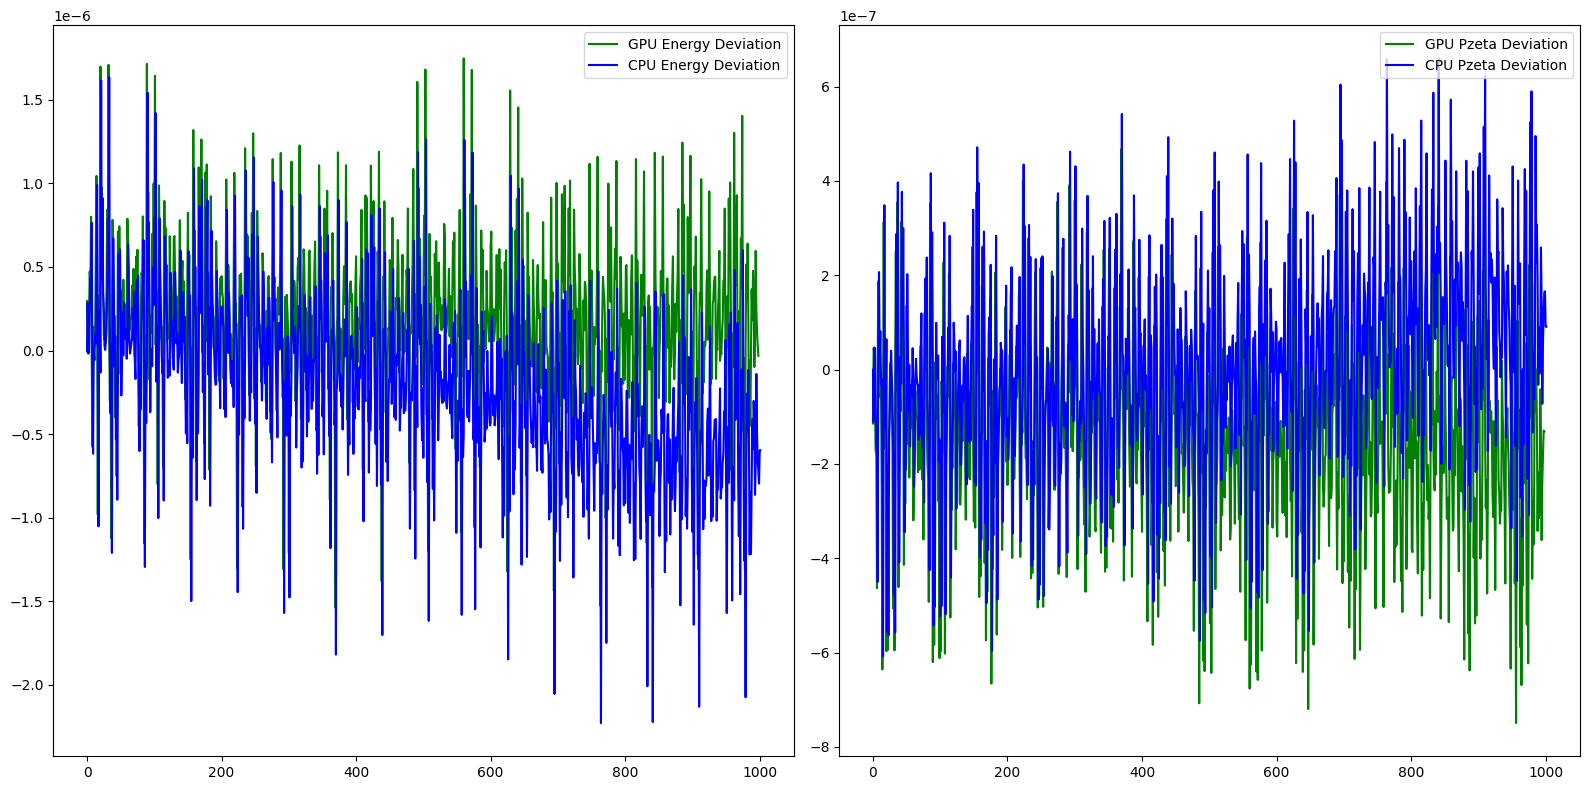

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))


helicity = -1

cpu_E, cpu_Pz, cpu_Ep = saw_Pzeta_Eprime_calc(saw, cpu_traj, cpu_vpar)
gpu_E, gpu_Pz, gpu_Ep = saw_Pzeta_Eprime_calc(saw, gpu_traj, gpu_vpar)

axes[0].plot((gpu_E - cpu_E[0])/cpu_E[0], color="green", label = "GPU Energy Deviation")
axes[0].plot((cpu_E - cpu_E[0])/cpu_E[0], color="blue", label = "CPU Energy Deviation")
axes[0].legend(loc="upper right")
axes[0].set_ylim()

axes[1].plot((gpu_Pz - cpu_Pz[0])/cpu_Pz[0], color="green", label = "GPU Pzeta Deviation")
axes[1].plot((cpu_Pz - cpu_Pz[0])/cpu_Pz[0], color="blue", label = "CPU Pzeta Deviation")
axes[1].legend(loc="upper right")

plt.tight_layout();
plt.show();
